In [1]:
import env
import pandas as pd
import utilities as utils
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle_census import wrangle_census_df
from scipy import stats
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.cluster import KMeans
from sklearn.ensemble import GradientBoostingRegressor
from cluster import generate_elbow_plot, fit_clusters, rename_clusters

# Predicting income from categorical data? Not quite there yet...

## Executive Summary
1. I was able to increase the explained variance score from 0% to 18%
    * Explained variance increased from 12% to 18% between iterations
2. Age had a .14 correlation with total annual income
    * Clusters also appeared to be along divisions in age
3. The data and my modeling method may not best suited for the problem I wanted to tackle

## Planning
The Agile Kanban methodology was used to map out the tasks for this project. The Kanban board used can be found [here](https://github.com/david-ryan-alviola/individual-project/projects/1).

The original research that this data was used for was to create a classification model that predicted whether or not an individual made less than 50_000 USD or not. I wanted to expand on this and set the lofty goal of using the data to create a regression model that would use features made from clusters to predict total annual income.

After scanning the data, I wanted to explore these hypotheses:
1. Does private or public affect income?
2. Does sex affect income?
3. Does race affect income?
4. Which occupation makes the most on average?
5. Does belonging to a union affect income?
6. Does having investments affect income?
    * I needed to make new feature since I could not factor in the figures directly
7. Does being married affect total annual income?
8. Does age correlate with total annual income?
9. Does education affect total income?
    * This was done on the second iteration
    
I planned to only use features that were already in the data set and not scale for the first iteration of the model. The second iteration would have engineered features, be scaled, and utilize clusters. I would then select the best perfoming regression model to apply to the test data and evaluate its performance.

## Acquisition
Data was obtained from the UCI Machine Learning Repository and can be downloaded [here](https://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/census.tar.gz). The data is already split into training and test data, but I decided to merge the two together and create my own splits. This is scripted into `acquire_census.py` which returns the entire data set as a data frame.

In [55]:
census_df = pd.read_csv(env.data_path + '/census/census-income.data', delimiter=',', header=None)
census_test_df = pd.read_csv(env.data_path + '/census/census-income.test', delimiter=',', header=None)
    
census_df = pd.concat([census_df, census_test_df])

## Preparation
The first main preparation task was renaming all the columns since the CSV file did not have a header row.

In [56]:
census_df.columns

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41],
           dtype='int64')

I also took this opportunity to rename the columns to better formatted and more clear names versus what was in the data dictionary on the NAMES file. I named any columns that I didn't think were useful to "drop" and scripted this in `_generate_drop_column_list` in the `prepare_census.py` file.

Next, I noticed that the hourly wage figures seemed very high with the mean value being 55. This was odd because the other monetary values (capital gains, capital losses, dividends) appeared to be in dollars. I assumed that the hourly wages were converted to cents, so I divided the figures by 100.

In [60]:
census_df[5].describe()

count    299285.000000
mean         55.105027
std         273.340729
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        9999.000000
Name: 5, dtype: float64

Since the data set contained children, students, and other non-workers, I selected for individuals 18 and older, as well as had worked for 52 weeks. I also noticed that some people had an hourly wage of zero, so I selected for individuals that had an hourly wage of over zero.

An odd thing I noticed was that the string values had leading and trailing whitespaces. I discovered this when trying to subset based on certain values. I stripped whitespace and replaced internal spaces with underscore with the `_strip_whitespace_from_values` function.

The data set also had some rows with the same index value, so I removed them with the `_drop_duplicate_rows` function rather than try to figure out if they were unique and then make them uniquely indexed.

Luckily, the data set did not have any nulls or empty values, so nothing had to be done there.

In [61]:
utils.show_missing_value_stats_by_col(census_df)

num_rows_missing  pct_rows_missing
0                  0               0.0
1                  0               0.0
2                  0               0.0
3                  0               0.0
4                  0               0.0
5                  0               0.0
6                  0               0.0
7                  0               0.0
8                  0               0.0
9                  0               0.0
10                 0               0.0
11                 0               0.0
12                 0               0.0
13                 0               0.0
14                 0               0.0
15                 0               0.0
16                 0               0.0
17                 0               0.0
18                 0               0.0
19                 0               0.0
20                 0               0.0
21                 0               0.0
22                 0               0.0
23                 0               0.0
24                 0               0.0
25                 0               0.0
26                 0               0.0
27                 0               0.0
28                 0               0.0
29                 0               0.0
30                 0               0.0
31                 0               0.0
32                 0               0.0
33                 0               0.0
34                 0               0.0
35                 0               0.0
36                 0               0.0
37                 0               0.0
38                 0               0.0
39                 0               0.0
40                 0               0.0
41                 0               0.0

In [62]:
utils.show_missing_value_stats_by_row(census_df)

num_rows  pct_cols_missing
num_cols_missing                            
0                   299285               0.0

In [63]:
utils.nan_null_empty_check(census_df)

NaN values
Empty DataFrame
Columns: [rows, columns]
Index: []
--------------------------------
Empty values
Empty DataFrame
Columns: [rows, columns]
Index: []
--------------------------------


{'nan_positions': (array([], dtype=int64), array([], dtype=int64)),
 'empty_positions': (array([], dtype=int64), array([], dtype=int64))}

I also thought that this data set had total income as part of it, but I had to calculate an individuals total income by multiplying the hourly wage by 40 hours (standard work week) and then multiplying by 52 (weeks worked in a year). I named this `total_annual_income` and made it my target variable.

In the second iteration, I added the `_engineer_features` function to my `prepare_census.py` file. I added the `has_investments` feature which summed `capital_gains`, `capital_losses`, and `total_dividends` and if it was non-zero, had a value of 1 and 0 otherwise. I created an `is_married` field which was really just a simplification of the `maritial_status` responses. I also simplified `education` by binning the responses into "not_high_school_grad", "is_high_school_grad", "is_college_grad", and "is_post_grad". Finally, I simplified the `worker_class` responses into either "is_public" or "is_private".

Outliers were not handled because the resulting data would be below the 10_000 observations required of this project.

I scripted both the `acquire_census.py` and `prepare_census.py` functions into `wrangle_census.py` which returns prepared train, validate, and test samples.

In [72]:
train, validate, test = wrangle_census_df()

### [Data Dictionary]()

## Exploration

In [85]:
train.columns

Index(['age', 'worker_class', 'education', 'hourly_wage', 'marital_status',
       'major_industry_code', 'major_occupation_code', 'race',
       'of_hispanic_origin', 'sex', 'is_union_member', 'capital_gains',
       'capital_losses', 'total_dividends', 'household_summary',
       'company_size', 'country_of_father', 'country_of_mother',
       'birth_country', 'citizenship', 'is_self_employed', 'weeks_worked',
       'year', 'total_annual_income', 'is_married', 'has_investments',
       'is_public', 'Male', 'White', 'belongs_to_union', 'is_college_grad',
       'is_high_school_grad', 'is_post_grad', 'not_high_school_grad'],
      dtype='object')

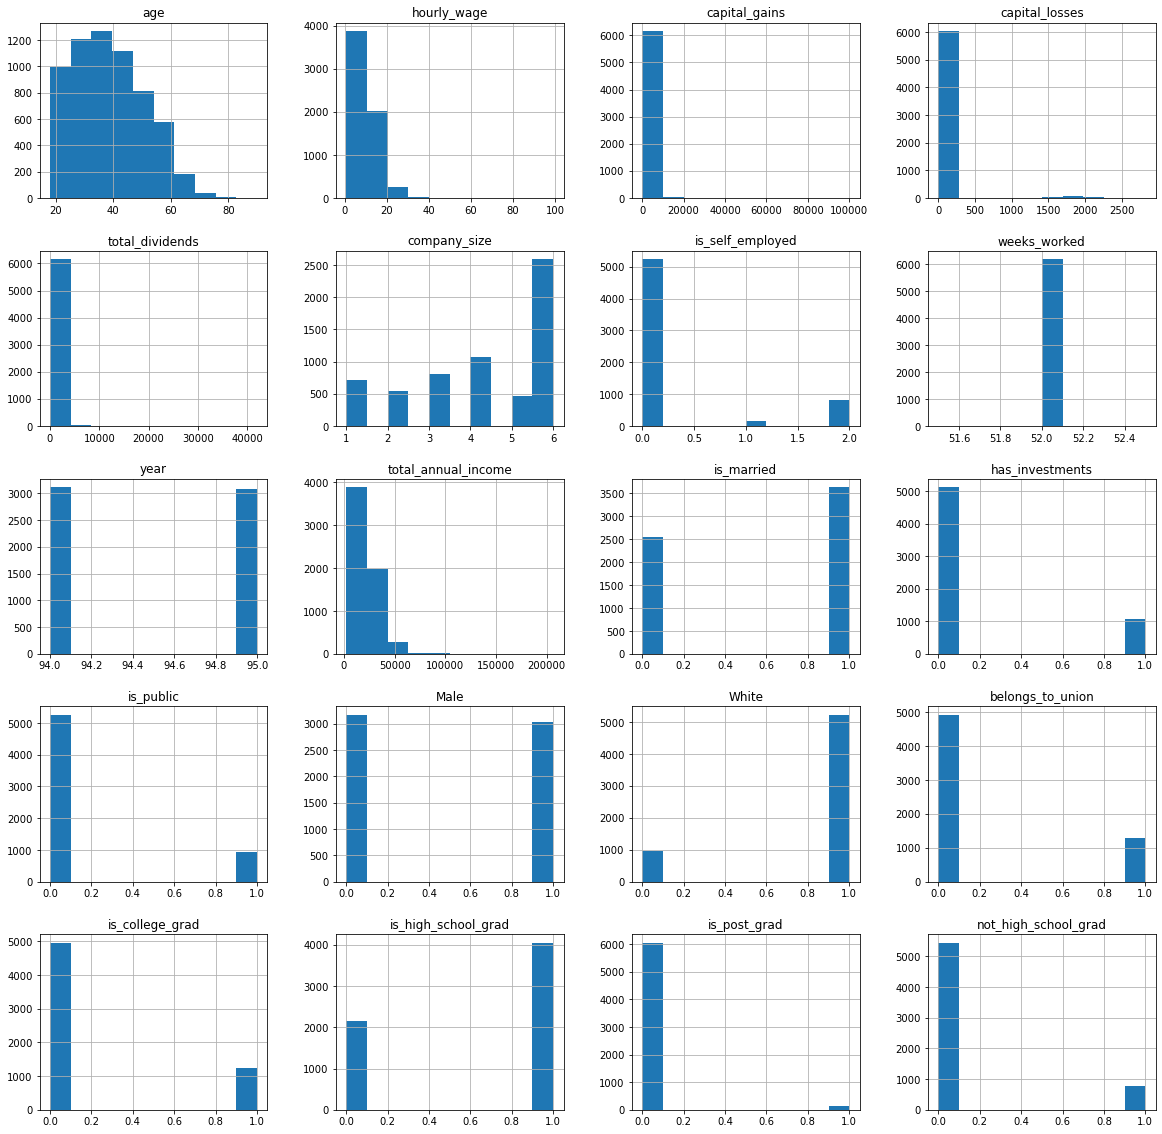

In [3]:
train.hist(figsize=[20,20])
plt.show()

In [5]:
cat_vars = ['worker_class', 'education', 'marital_status', 'major_occupation_code', 'race', 'is_union_member', 'region',\
            'state', 'sex']
cont_vars = ['age', 'hourly_wage', 'capital_gains', 'capital_losses', 'total_dividends', 'total_annual_income']

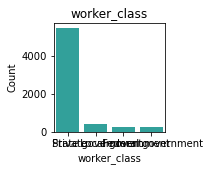

                            worker_class  Count  Percent
 Private                         Private   5440    85.40
 Local government       State government    425     6.67
 Federal government     Local government    265     4.16
 State government     Federal government    240     3.77
_________________________________________________________________


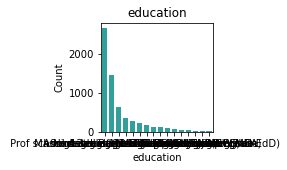

                                                                       education  \
 High school graduate                                       High school graduate   
 Some college but no degree               Prof school degree (MD DDS DVM LLB JD)   
 Bachelors degree(BA AB BS)                           Some college but no degree   
 Associates degree-occup /vocational                       12th grade no diploma   
 Associates degree-academic program          Associates degree-occup /vocational   
 11th grade                                                           11th grade   
 10th grade                               Masters degree(MA MS MEng MEd MSW MBA)   
 Masters degree(MA MS MEng MEd MSW MBA)                               10th grade   
 7th and 8th grade                            Associates degree-academic program   
 9th grade                                            Bachelors degree(BA AB BS)   
 5th or 6th grade                                              7th and 8th g

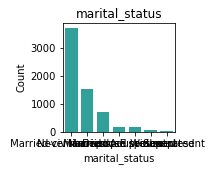

                                                    marital_status  Count  \
 Married-civilian spouse present                     Never married   3697   
 Never married                     Married-civilian spouse present   1548   
 Divorced                                                 Divorced    719   
 Separated                                   Married-spouse absent    177   
 Widowed                                Married-A F spouse present    158   
 Married-spouse absent                                     Widowed     51   
 Married-A F spouse present                              Separated     20   

                                  Percent  
 Married-civilian spouse present    58.04  
 Never married                      24.30  
 Divorced                           11.29  
 Separated                           2.78  
 Widowed                             2.48  
 Married-spouse absent               0.80  
 Married-A F spouse present          0.31  
_______________________________

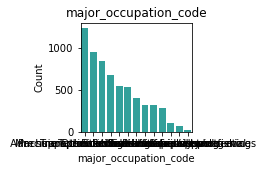

                                                         major_occupation_code  \
 Adm support including clerical                 Adm support including clerical   
 Precision production craft & repair                             Other service   
 Other service                             Precision production craft & repair   
 Machine operators assmblrs & inspctrs   Machine operators assmblrs & inspctrs   
 Professional specialty                                                  Sales   
 Sales                                      Transportation and material moving   
 Executive admin and managerial                Technicians and related support   
 Handlers equip cleaners etc                            Professional specialty   
 Transportation and material moving                        Protective services   
 Technicians and related support                Executive admin and managerial   
 Protective services                              Handlers equip cleaners etc    
 Farming forestr

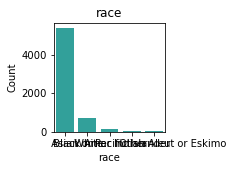

                                                      race  Count  Percent
 White                                               Black   5386    84.55
 Black                                               White    702    11.02
 Asian or Pacific Islander       Asian or Pacific Islander    157     2.46
 Other                                               Other     64     1.00
 Amer Indian Aleut or Eskimo   Amer Indian Aleut or Eskimo     61     0.96
_________________________________________________________________


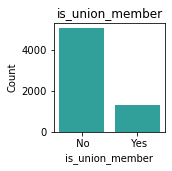

     is_union_member  Count  Percent
 No               No   5064     79.5
 Yes             Yes   1306     20.5
_________________________________________________________________


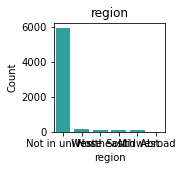

                            region  Count  Percent
 Not in universe   Not in universe   5903    92.67
 South                        West    150     2.35
 Midwest                 Northeast    129     2.03
 West                        South     94     1.48
 Northeast                 Midwest     92     1.44
 Abroad                     Abroad      2     0.03
_________________________________________________________________


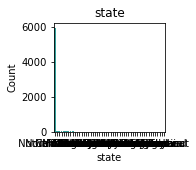

                                       state  Count  Percent
 Not in universe             Not in universe   5903    92.67
 California                       California     38     0.60
 Utah                         North Carolina     29     0.46
 ?                                   Florida     29     0.46
 Oklahoma                         New Mexico     24     0.38
 Florida                           Minnesota     24     0.38
 Indiana                                Utah     23     0.36
 North Carolina                        Maine     21     0.33
 Minnesota                          Missouri     18     0.28
 North Dakota                       Virginia     17     0.27
 Wyoming                                   ?     15     0.24
 New Mexico                             Ohio     15     0.24
 Michigan                      West Virginia     11     0.17
 Nevada                         South Dakota     11     0.17
 Missouri                             Abroad     10     0.16
 Maine                  

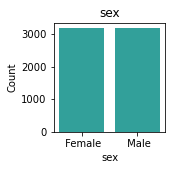

             sex  Count  Percent
 Female   Female   3186    50.02
 Male       Male   3184    49.98
_________________________________________________________________


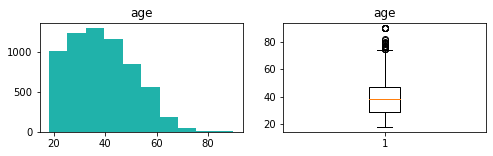

count    6370.000000
mean       38.540816
std        12.161019
min        18.000000
25%        29.000000
50%        38.000000
75%        47.000000
max        90.000000
Name: age, dtype: float64


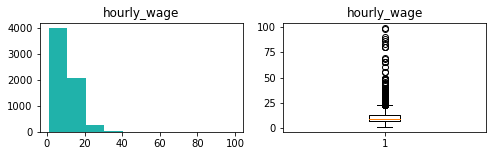

count    6370.000000
mean       10.625885
std         6.393609
min         1.000000
25%         6.500000
50%         9.000000
75%        13.000000
max        99.160000
Name: hourly_wage, dtype: float64


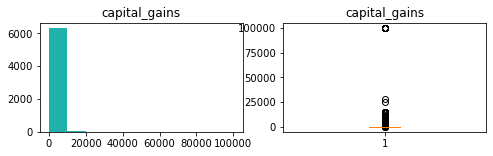

count     6370.000000
mean       442.694819
std       4236.744255
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital_gains, dtype: float64


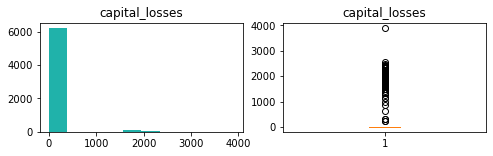

count    6370.000000
mean       45.813658
std       293.171797
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      3900.000000
Name: capital_losses, dtype: float64


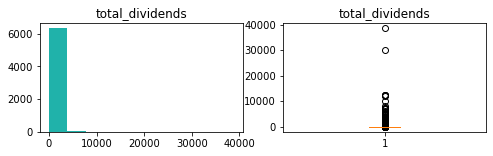

count     6370.000000
mean        86.953218
std        818.558882
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      38758.000000
Name: total_dividends, dtype: float64


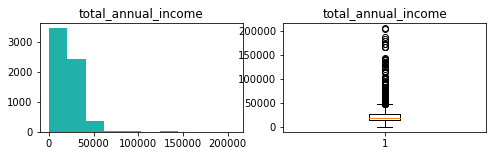

count      6370.000000
mean      22585.676013
std       14285.025610
min          79.000000
25%       13728.000000
50%       18852.400000
75%       27560.000000
max      206252.800000
Name: total_annual_income, dtype: float64


In [24]:
utils.explore_univariate(train, cat_vars, cont_vars)

worker_class vs total_annual_income
-------------------------------


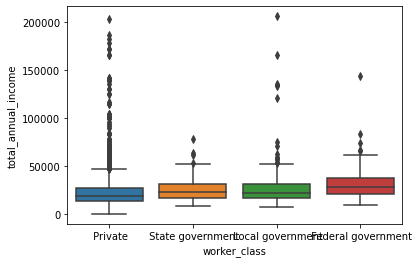

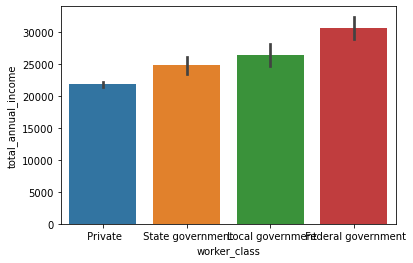

-------------------------------
Mean total_annual_income by worker_class:  
worker_class
 Federal government    30570.908679
 Local government      26352.656000
 Private               21805.873566
 State government      24773.476667
Name: total_annual_income, dtype: float64

education vs total_annual_income
-------------------------------


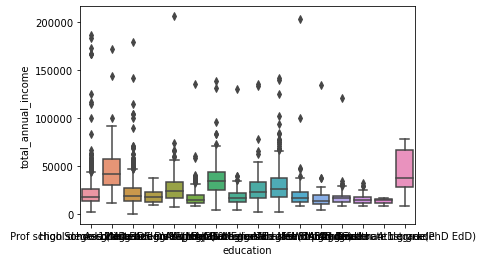

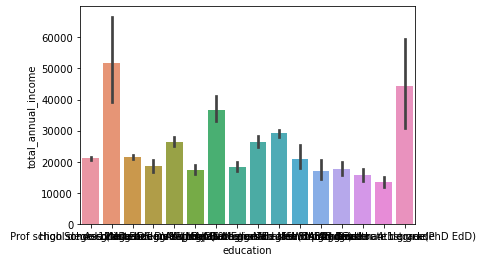

-------------------------------
Mean total_annual_income by education:  
education
 10th grade                                18238.929730
 11th grade                                17422.103509
 12th grade no diploma                     18637.926316
 1st 2nd 3rd or 4th grade                  15700.632432
 5th or 6th grade                          16891.219277
 7th and 8th grade                         20782.912281
 9th grade                                 17513.282243
 Associates degree-academic program        26338.459854
 Associates degree-occup /vocational       26385.957593
 Bachelors degree(BA AB BS)                29088.773668
 Doctorate degree(PhD EdD)                 44496.977778
 High school graduate                      21089.900038
 Less than 1st grade                       13572.000000
 Masters degree(MA MS MEng MEd MSW MBA)    36740.925000
 Prof school degree (MD DDS DVM LLB JD)    51632.911111
 Some college but no degree                21614.201909
Name: total_annual_in

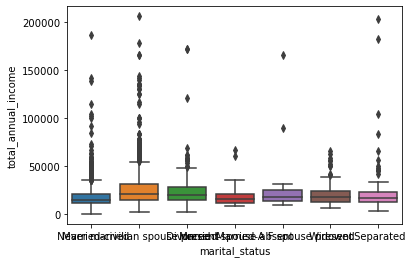

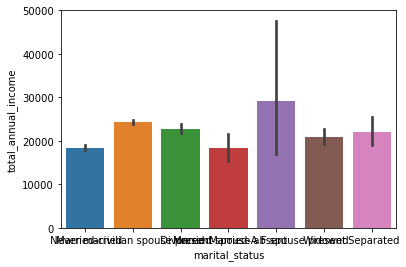

-------------------------------
Mean total_annual_income by marital_status:  
marital_status
 Divorced                           22805.272323
 Married-A F spouse present         29270.140000
 Married-civilian spouse present    24426.922315
 Married-spouse absent              18481.509804
 Never married                      18384.818346
 Separated                          21961.787571
 Widowed                            20838.851899
Name: total_annual_income, dtype: float64

major_occupation_code vs total_annual_income
-------------------------------


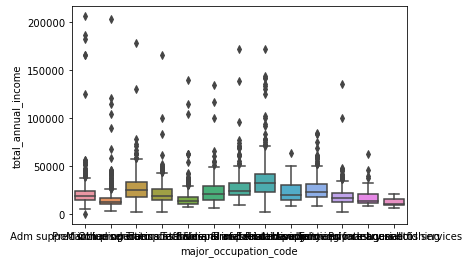

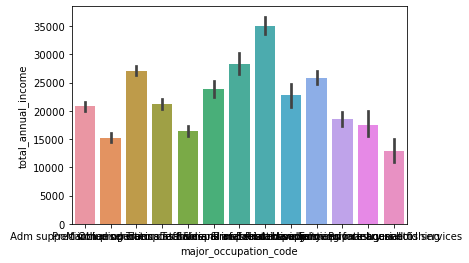

-------------------------------
Mean total_annual_income by major_occupation_code:  
major_occupation_code
 Adm support including clerical           20816.614827
 Executive admin and managerial           25904.623844
 Farming forestry and fishing             17536.963380
 Handlers equip cleaners etc              18521.903364
 Machine operators assmblrs & inspctrs    21252.673638
 Other service                            15134.893567
 Precision production craft & repair      27144.536326
 Private household services               12882.842105
 Professional specialty                   35035.429550
 Protective services                      22798.926126
 Sales                                    16378.368889
 Technicians and related support          28269.908772
 Transportation and material moving       23874.287421
Name: total_annual_income, dtype: float64

race vs total_annual_income
-------------------------------


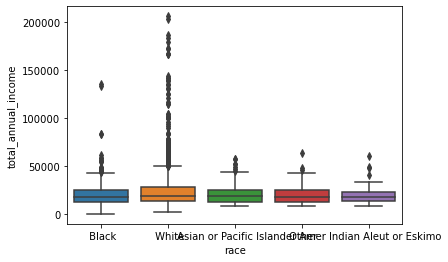

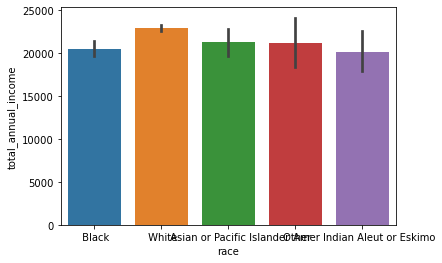

-------------------------------
Mean total_annual_income by race:  
race
 Amer Indian Aleut or Eskimo    20114.049180
 Asian or Pacific Islander      21241.015287
 Black                          20528.689744
 Other                          21191.103125
 White                          22937.539733
Name: total_annual_income, dtype: float64

is_union_member vs total_annual_income
-------------------------------


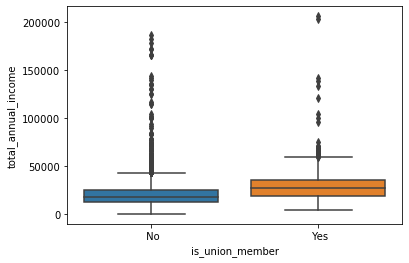

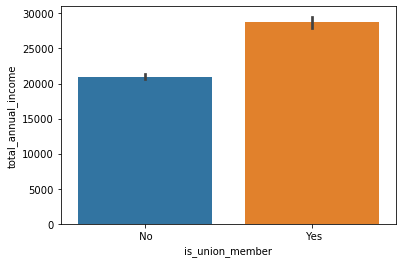

-------------------------------
Mean total_annual_income by is_union_member:  
is_union_member
 No     20993.721722
 Yes    28758.460490
Name: total_annual_income, dtype: float64

region vs total_annual_income
-------------------------------


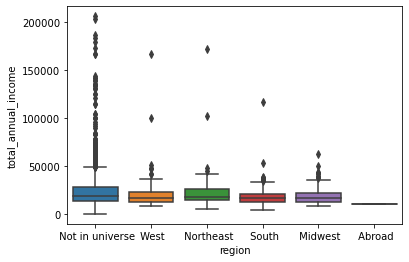

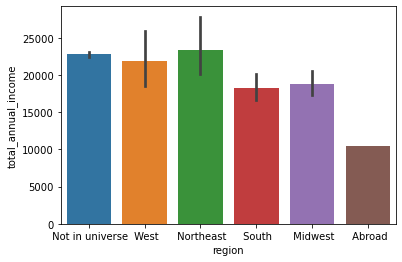

-------------------------------
Mean total_annual_income by region:  
region
 Abroad             10400.000000
 Midwest            18790.254264
 Northeast          23322.245652
 Not in universe    22781.088362
 South              18284.449333
 West               21924.838298
Name: total_annual_income, dtype: float64

state vs total_annual_income
-------------------------------


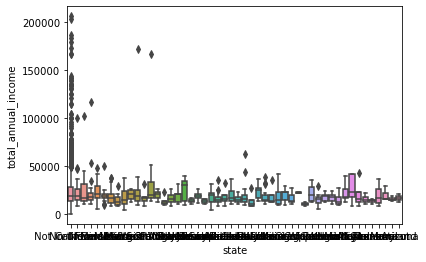

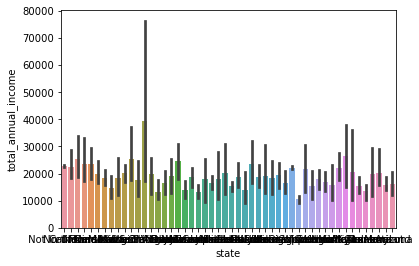

-------------------------------
Mean total_annual_income by state:  
state
 ?                       25191.937931
 Abroad                  13364.000000
 Alabama                 13464.533333
 Alaska                  26416.000000
 Arizona                 16286.400000
 Arkansas                17837.750000
 California              22578.805263
 Colorado                10504.000000
 Connecticut             19905.600000
 Delaware                20280.000000
 District of Columbia    22183.200000
 Florida                 23466.791667
 Georgia                 15433.885714
 Illinois                19011.400000
 Indiana                 16366.217391
 Iowa                    20106.666667
 Kansas                  18181.511111
 Kentucky                17000.000000
 Louisiana               13860.600000
 Maine                   14637.880000
 Maryland                15695.000000
 Massachusetts           17950.400000
 Michigan                22159.109091
 Minnesota               19957.544444
 Mississippi 

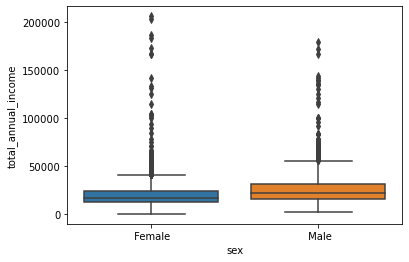

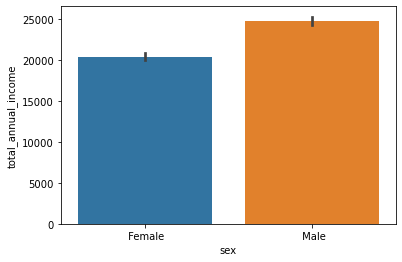

-------------------------------
Mean total_annual_income by sex:  
sex
 Female    20404.122599
 Male      24768.599749
Name: total_annual_income, dtype: float64



In [6]:
utils.explore_bivariate_categorical('total_annual_income', cat_vars, train)

age vs total_annual_income
-------------------------------


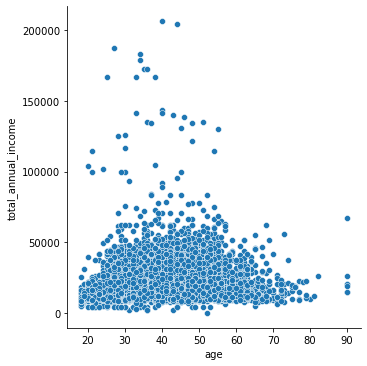

-------------------------------
Correlation between age and total_annual_income:  0.1410620448217601
P value:  1.1330538456315713e-29

hourly_wage vs total_annual_income
-------------------------------


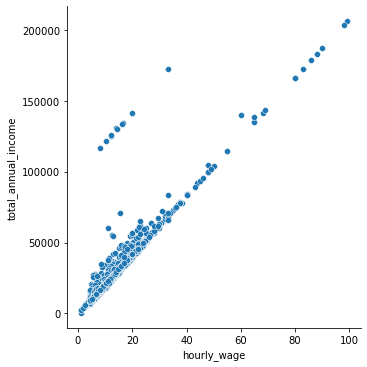

-------------------------------
Correlation between hourly_wage and total_annual_income:  0.9525015047091703
P value:  0.0

capital_gains vs total_annual_income
-------------------------------


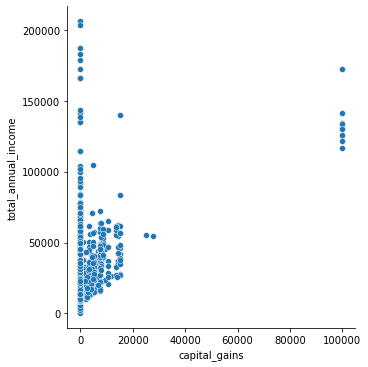

-------------------------------
Correlation between capital_gains and total_annual_income:  0.35929850971738864
P value:  2.043233009253663e-193

capital_losses vs total_annual_income
-------------------------------


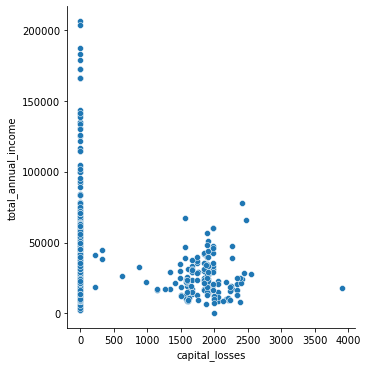

-------------------------------
Correlation between capital_losses and total_annual_income:  0.03508269991371232
P value:  0.005104837421092028

total_dividends vs total_annual_income
-------------------------------


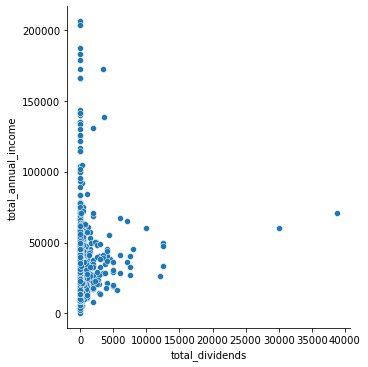

-------------------------------
Correlation between total_dividends and total_annual_income:  0.1295162257515052
P value:  3.0997917126837565e-25

total_annual_income vs total_annual_income
-------------------------------


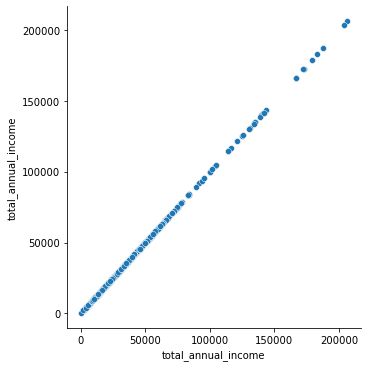

-------------------------------
Correlation between total_annual_income and total_annual_income:  1.0
P value:  0.0



In [7]:
utils.explore_bivariate_continuous('total_annual_income', cont_vars, train)

age vs total_annual_income
-------------------------------


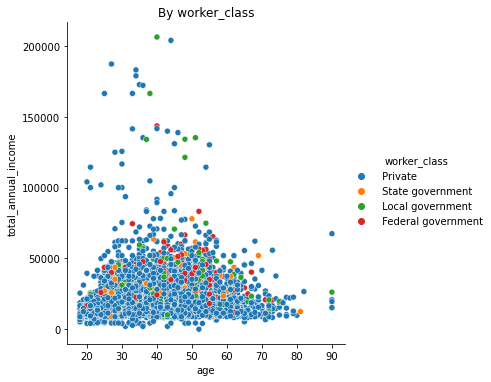

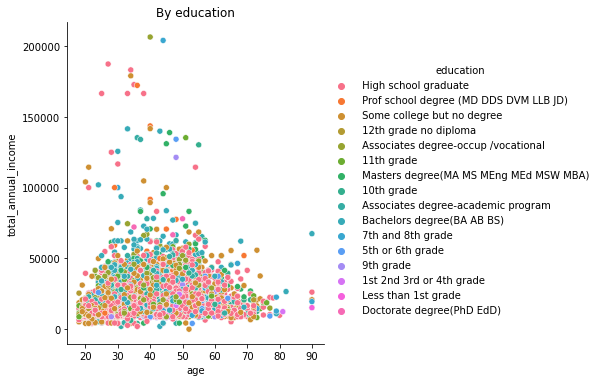

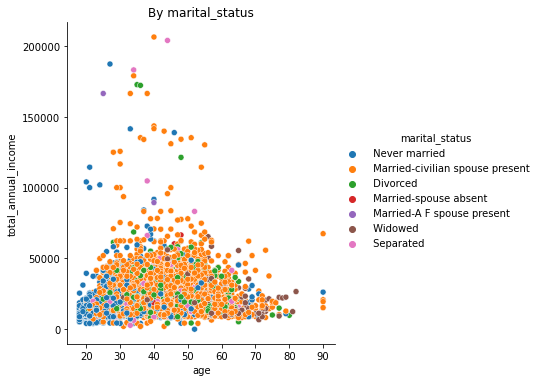

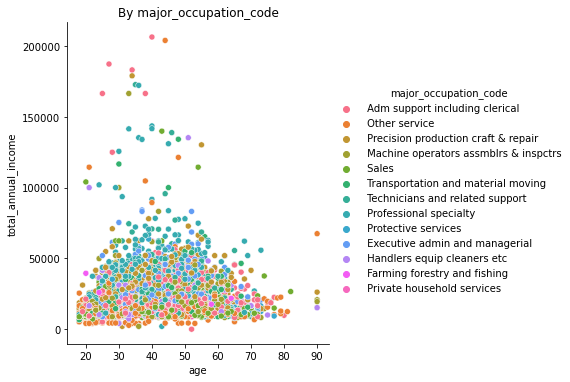

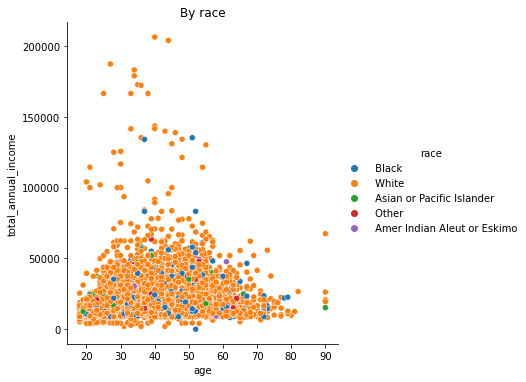

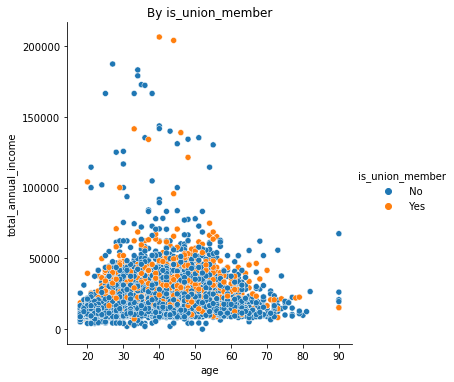

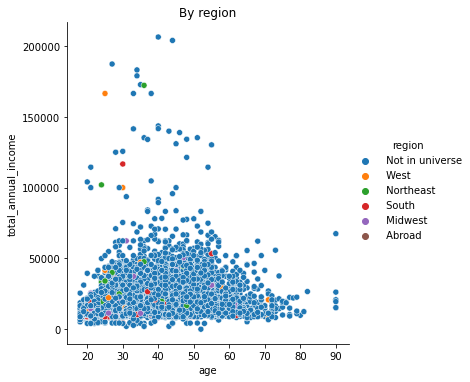

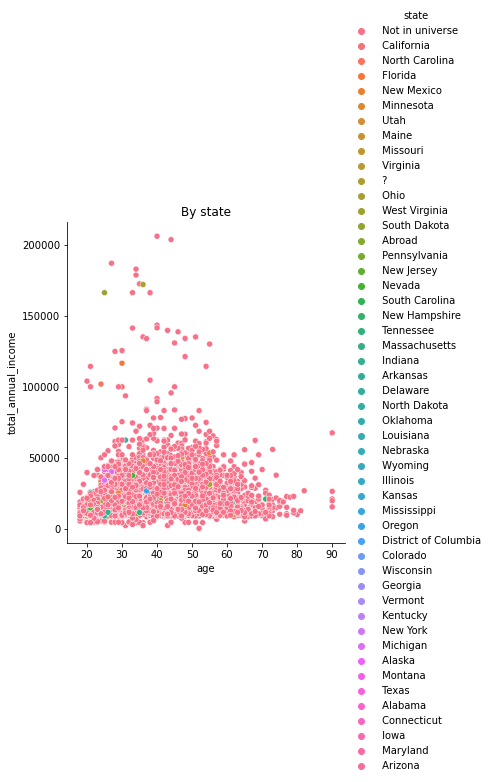

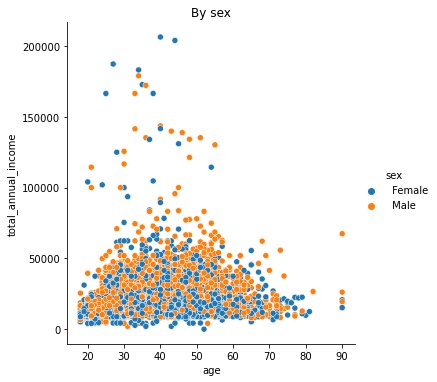


hourly_wage vs total_annual_income
-------------------------------


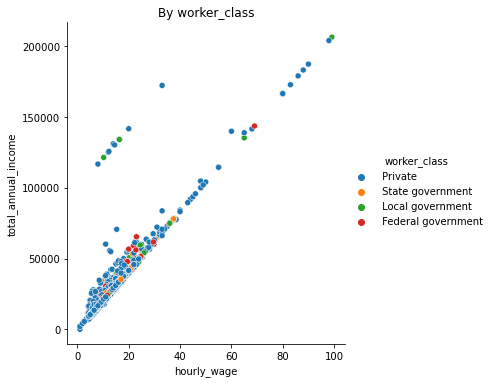

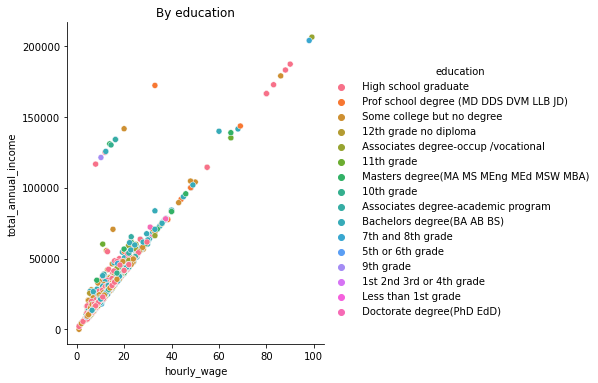

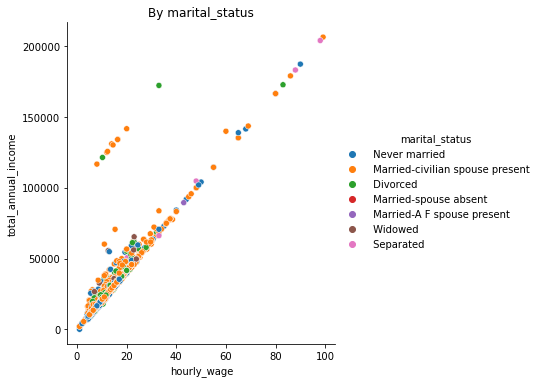

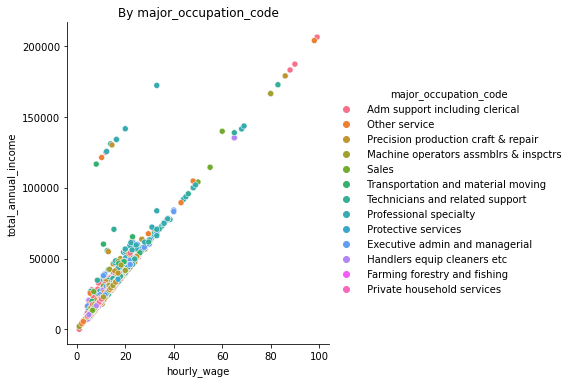

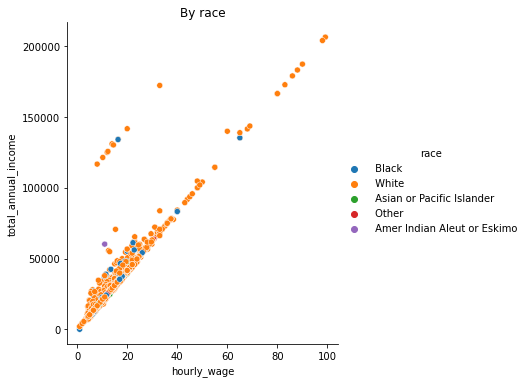

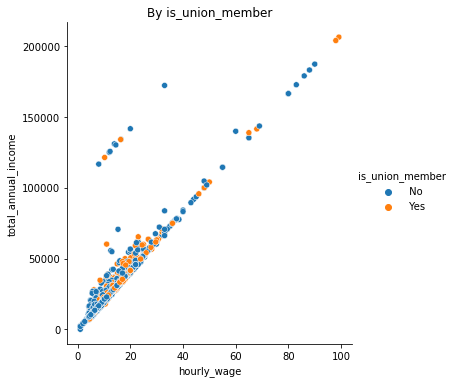

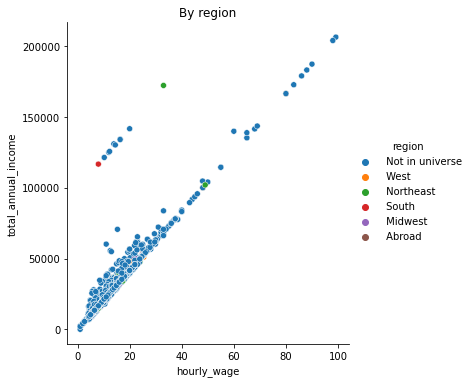

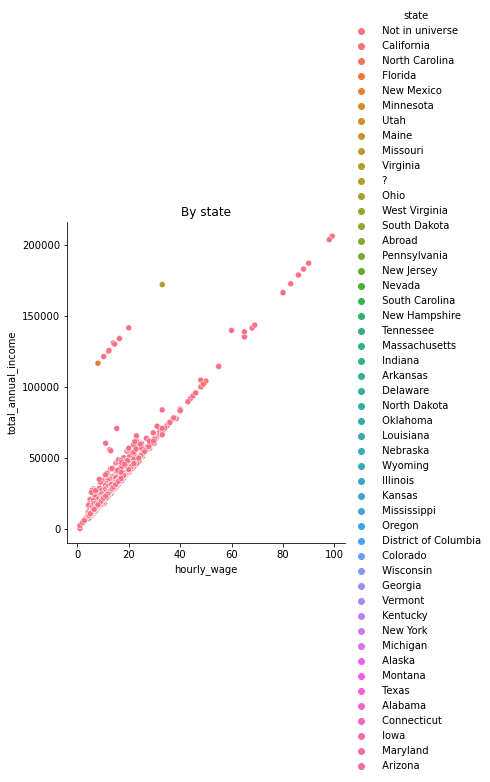

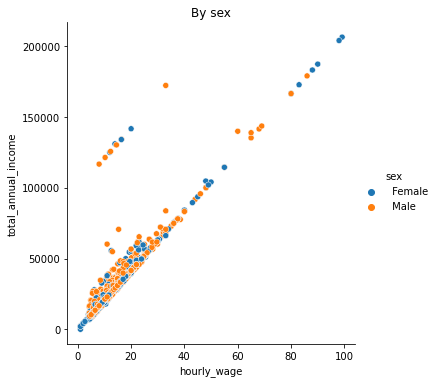


capital_gains vs total_annual_income
-------------------------------


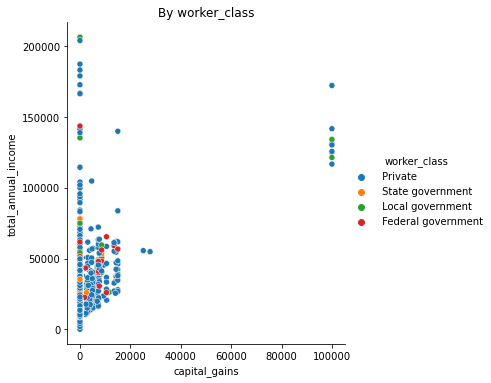

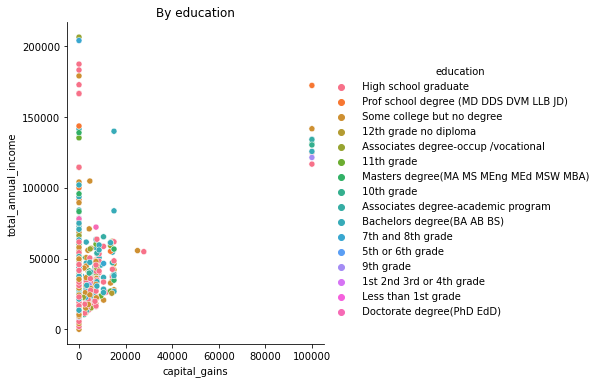

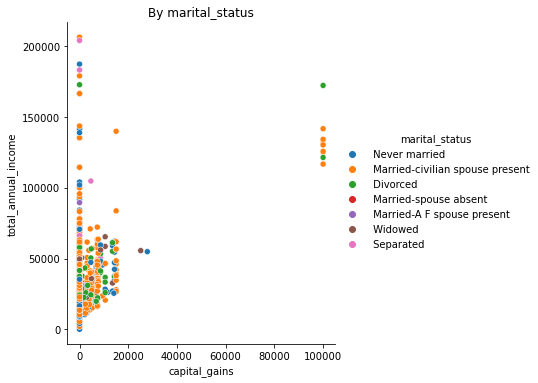

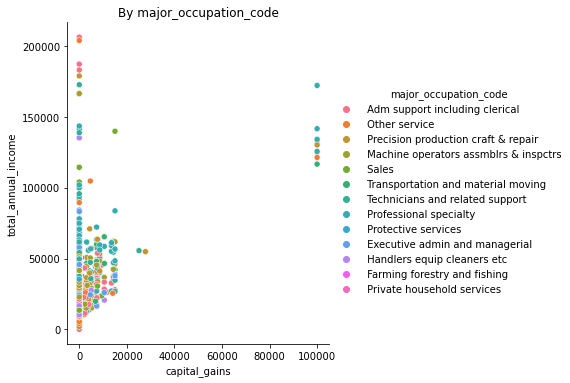

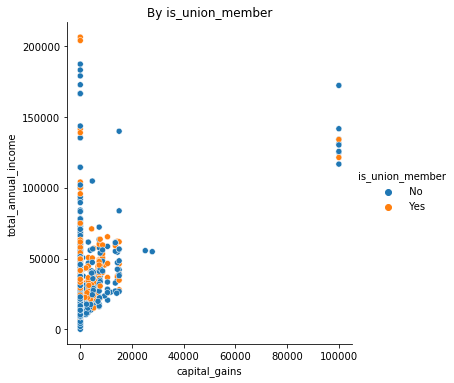

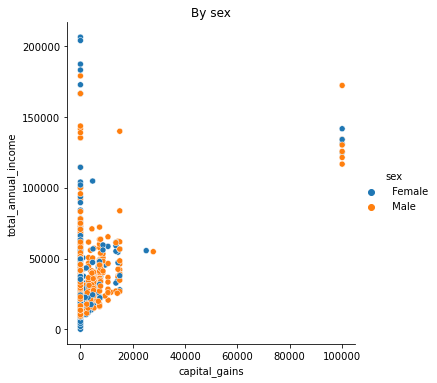


capital_losses vs total_annual_income
-------------------------------


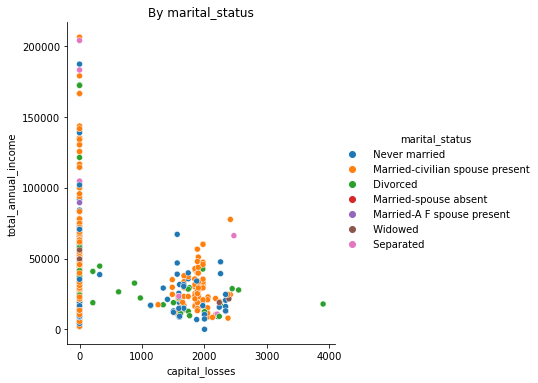

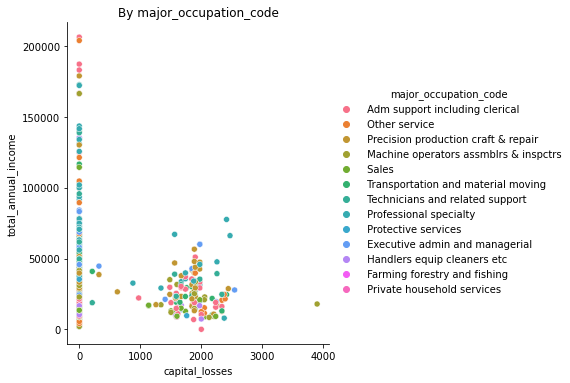

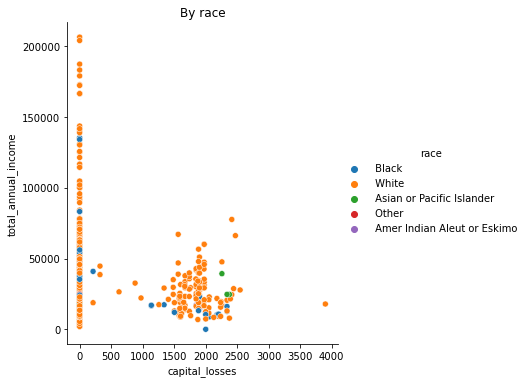

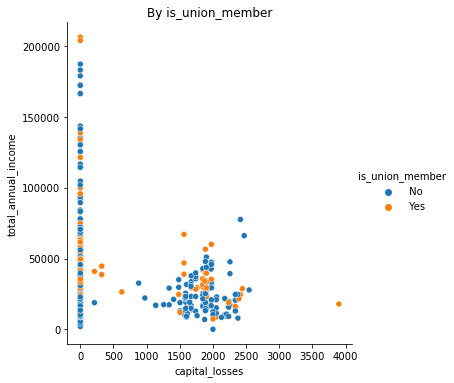

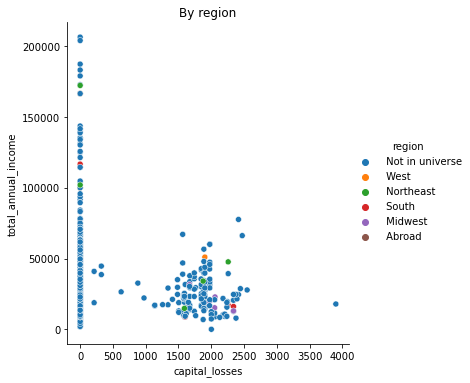

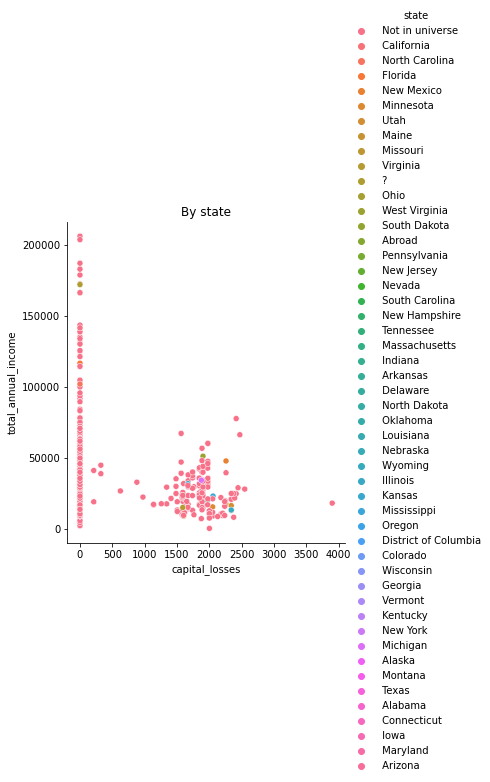


total_dividends vs total_annual_income
-------------------------------


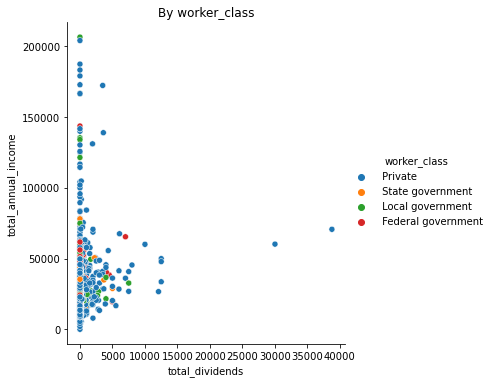

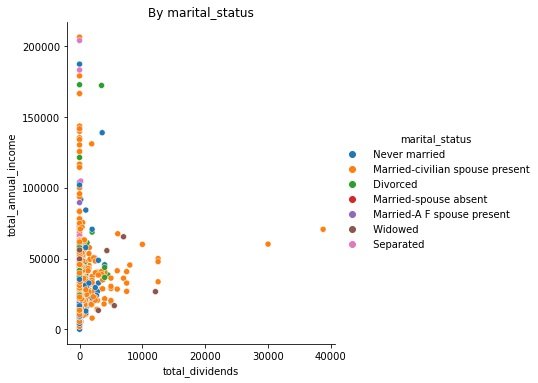

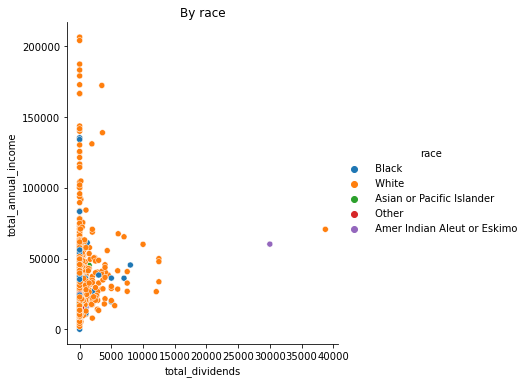

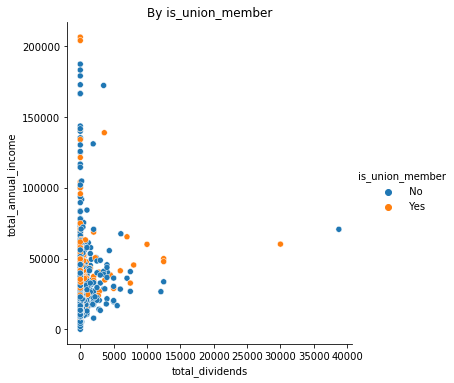

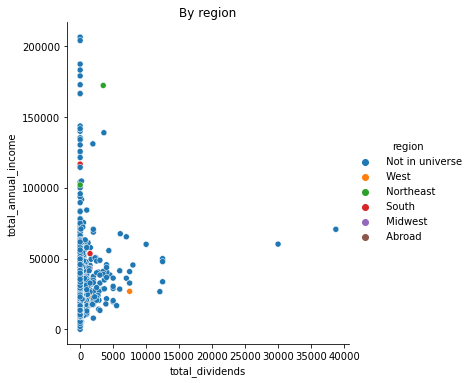

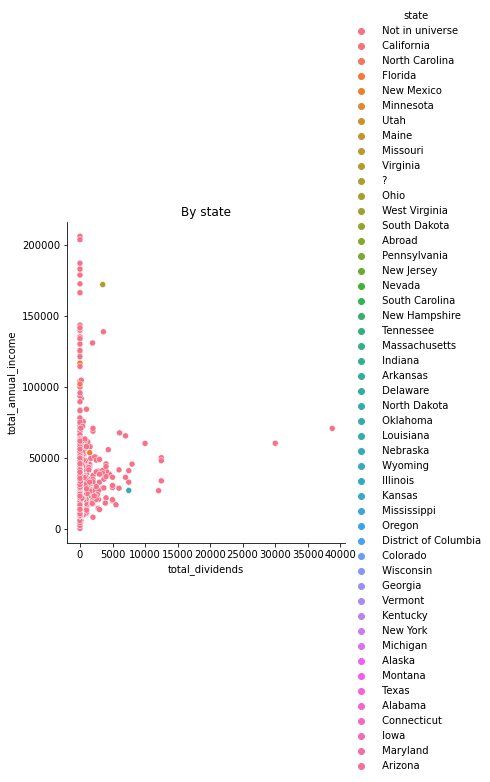

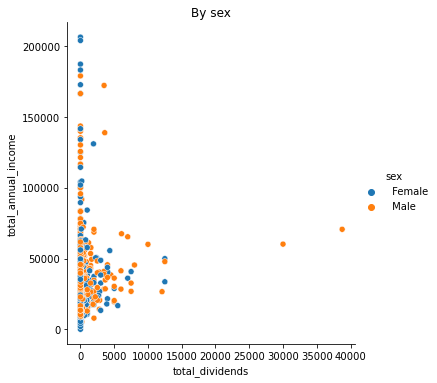


total_annual_income vs total_annual_income
-------------------------------


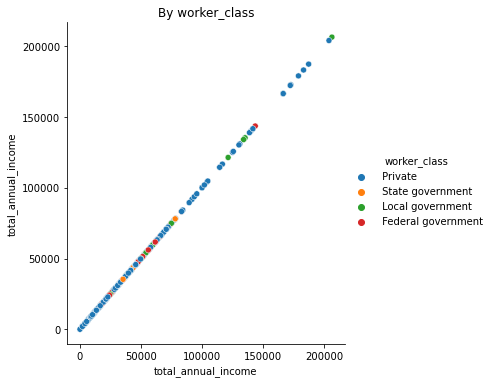

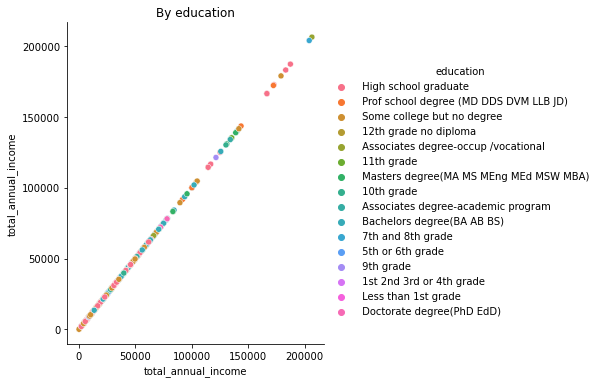

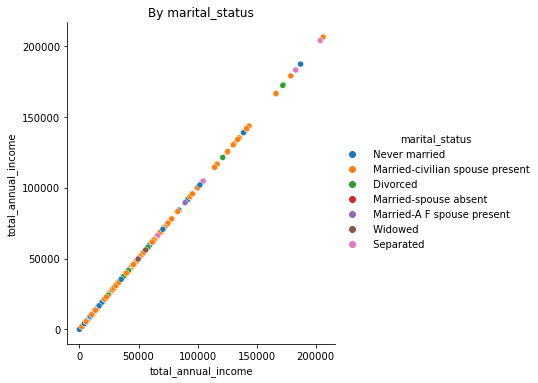

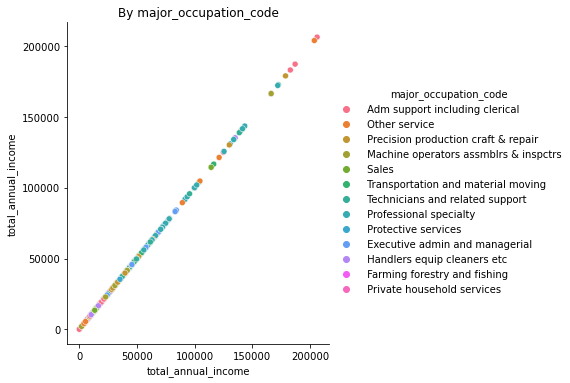

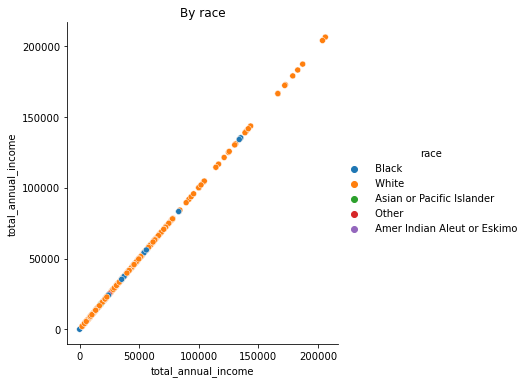

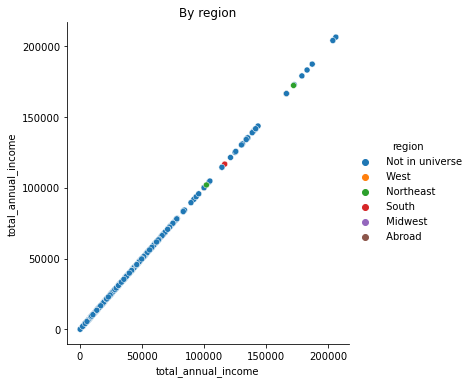

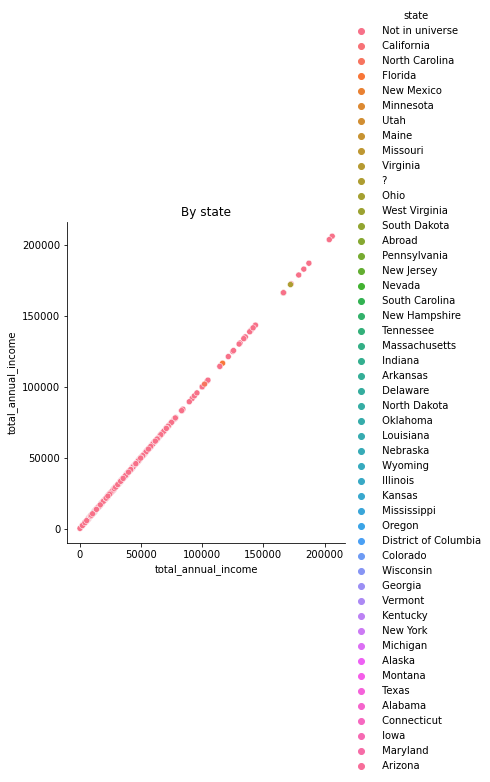

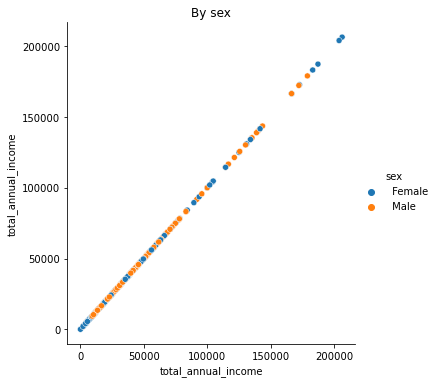

In [8]:
utils.explore_multivariate_(cont_vars, cat_vars, 'total_annual_income', train)

# Hypothesis testing

In [66]:
alpha = .05

1. Do private workers make more on average than the population?
* make new feature on iteration 2 called (is_public)

In [73]:
null_hyp = "Private workers do not have a higher income than the population"
alt_hyp = "Private workers have a higher income than the population"

private = train[train.worker_class == 'is_private']

t, p = stats.ttest_1samp(private.total_annual_income, train['total_annual_income'].mean())
utils.evaluate_hypothesis_ttest(p, t, alpha, "greater", null_hypothesis=null_hyp, alternative_hypothesis=alt_hyp)

------------------------------------------
t:  -4.16090493848247, p:  3.2205239601373316e-05, a:  0.05

We fail to reject the null hypothesis:  Private workers do not have a higher income than the population
------------------------------------------


{'t': -4.16090493848247,
 'p': 3.2205239601373316e-05,
 'a': 0.05,
 'message': 'We fail to reject the null hypothesis:  Private workers do not have a higher income than the population',
 'reject_null': False}

2. Does sex affect total income?

In [74]:
null_hyp = "Female workers do not have a different income than the population"
alt_hyp = "Female workers have a different income than the population"

females = train[train.sex == 'Female']

t, p = stats.ttest_1samp(females.total_annual_income, train['total_annual_income'].mean())
utils.evaluate_hypothesis_ttest(p, t, alpha, null_hypothesis=null_hyp, alternative_hypothesis=alt_hyp)

------------------------------------------
t:  -9.059720901506472, p:  2.2342246806435017e-19, a:  0.05

We reject the null hypothesis. We move forward with the alternative hypothesis:  Female workers have a different income than the population
------------------------------------------


{'t': -9.059720901506472,
 'p': 2.2342246806435017e-19,
 'a': 0.05,
 'message': 'We reject the null hypothesis. We move forward with the alternative hypothesis:  Female workers have a different income than the population',
 'reject_null': True}

3. Does a certain race make more on average than the population?

In [77]:
null_hyp = "White workers do not have a higher income than the population"
alt_hyp = "White workers have a higher income than the population"

whites = train[train.White == 1]

t, p = stats.ttest_1samp(whites.total_annual_income, train['total_annual_income'].mean())
utils.evaluate_hypothesis_ttest(p, t, alpha, "greater", null_hypothesis=null_hyp, alternative_hypothesis=alt_hyp)

------------------------------------------
t:  1.4342912602166427, p:  0.15154905327361748, a:  0.05

We fail to reject the null hypothesis:  White workers do not have a higher income than the population
------------------------------------------


{'t': 1.4342912602166427,
 'p': 0.15154905327361748,
 'a': 0.05,
 'message': 'We fail to reject the null hypothesis:  White workers do not have a higher income than the population',
 'reject_null': False}

4. Do admin clerks make more than the population average?

In [80]:
null_hyp = "Admin workers do not have a higher income than the population"
alt_hyp = "Admin workers have a higher income than the population"

admins = train[train.major_occupation_code == 'Adm_support_including_clerical']

t, p = stats.ttest_1samp(admins.total_annual_income, train['total_annual_income'].mean())
utils.evaluate_hypothesis_ttest(p, t, alpha, "greater", null_hyp, alt_hyp)

------------------------------------------
t:  -3.588706274643038, p:  0.00034534604891789194, a:  0.05

We fail to reject the null hypothesis:  Admin workers do not have a higher income than the population
------------------------------------------


{'t': -3.588706274643038,
 'p': 0.00034534604891789194,
 'a': 0.05,
 'message': 'We fail to reject the null hypothesis:  Admin workers do not have a higher income than the population',
 'reject_null': False}

5. Does being in a union affect total income?

In [81]:
null_hyp = "Non-union workers do not have a different income than the population"
alt_hyp = "Non-union workers have a different income than the population"

non_union = train[train.is_union_member.str.strip() == 'No']

t, p = stats.ttest_1samp(non_union.total_annual_income, train['total_annual_income'].mean())
utils.evaluate_hypothesis_ttest(p, t, alpha, null_hypothesis=null_hyp, alternative_hypothesis=alt_hyp)

------------------------------------------
t:  -7.905765866178906, p:  3.2632461166866483e-15, a:  0.05

We reject the null hypothesis. We move forward with the alternative hypothesis:  Non-union workers have a different income than the population
------------------------------------------


{'t': -7.905765866178906,
 'p': 3.2632461166866483e-15,
 'a': 0.05,
 'message': 'We reject the null hypothesis. We move forward with the alternative hypothesis:  Non-union workers have a different income than the population',
 'reject_null': True}

7. Do married workers make more than the population average?

In [83]:
null_hyp = "Married workers do not have a higher income than the population"
alt_hyp = "Married workers have a higher income than the population"

married = train[train.is_married == 1]

t, p = stats.ttest_1samp(married.total_annual_income, train['total_annual_income'].mean())
utils.evaluate_hypothesis_ttest(p, t, alpha, "greater", null_hyp, alt_hyp)

------------------------------------------
t:  7.129616448046729, p:  1.2082461718185899e-12, a:  0.05

We reject the null hypothesis. We move forward with the alternative hypothesis:  Married workers have a higher income than the population
------------------------------------------


{'t': 7.129616448046729,
 'p': 1.2082461718185899e-12,
 'a': 0.05,
 'message': 'We reject the null hypothesis. We move forward with the alternative hypothesis:  Married workers have a higher income than the population',
 'reject_null': True}

8. Does age correlate with annual income?

In [84]:
null_hyp = "Age does not correlate with income"
alt_hyp = "Age correlates with income"

corr, p = stats.pearsonr(train.age, train.total_annual_income)
utils.evaluate_hypothesis_pcorrelation(corr, p, alpha, null_hypothesis=null_hyp, alternative_hypothesis=alt_hyp)

------------------------------------------
corr:  0.14773005592676247, p:  1.3807923679182174e-31, a:  0.05

We reject the null hypothesis. We move forward with the alternative hypothesis:  Age correlates with income
Correlation direction:  positive
------------------------------------------


{'corr': 0.14773005592676247,
 'p': 1.3807923679182174e-31,
 'a': 0.05,
 'reject_null': True,
 'message': 'We reject the null hypothesis. We move forward with the alternative hypothesis:  Age correlates with income',
 'correlation': 'positive'}

### Clustering

In [6]:
scale_cols = ['age', 'total_annual_income', 'is_married', 'has_investments',
       'is_public', 'Male', 'White', 'belongs_to_union', 'is_college_grad', 'is_high_school_grad', 'is_post_grad',
       'not_high_school_grad']

In [7]:
train_scaled, validate_scaled, test_scaled = utils.generate_scaled_splits(train[scale_cols], validate[scale_cols], test[scale_cols],\
                                                                          RobustScaler())

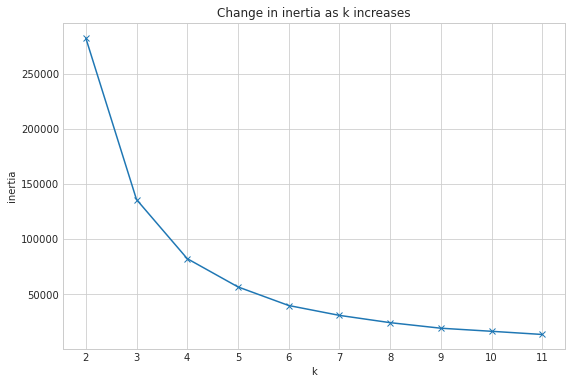

In [8]:
X_train, X_validate, X_test = generate_elbow_plot(train,validate, test, ['age', 'is_married'])

In [9]:
fit_clusters(train, validate, test, X_train, X_validate, X_test, 7, 'marriage_cluster', 'age', 'total_annual_income', 'is_married')

Age seemed to dominate the married clusters, so I did not use them.

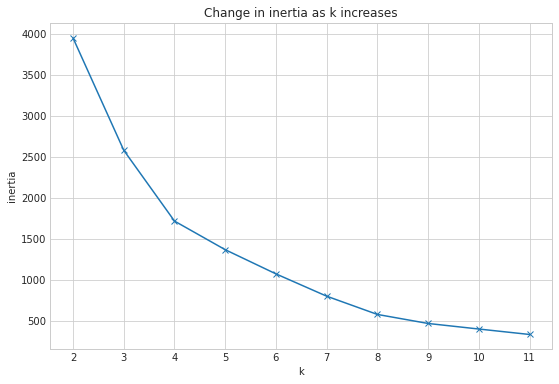

In [11]:
X_train, X_validate, X_test = generate_elbow_plot(train_scaled, validate_scaled, test_scaled, \
                                                  ['age', 'is_college_grad', 'is_high_school_grad', 'is_post_grad',\
                                                   'not_high_school_grad'])

In [12]:
fit_clusters(train, validate, test, X_train, X_validate, X_test, 6, 'education_cluster', 'age', 'total_annual_income', 'education')

In [13]:
education_dict = {'cluster_0' : '30_40_yr_post_grad', 'cluster_1' : '30_50_yr_high_school_grad',\
                  'cluster_2' : '50_plus_high_school_grad', 'cluster_3' : '20_30_yr_high_school_grad', 'cluster_4' : 'college_grad',\
                 'cluster_5' : '40_plus_post_grad'}

train = rename_clusters(education_dict, train, 'education_cluster')
validate = rename_clusters(education_dict, validate, 'education_cluster')
test = rename_clusters(education_dict, test, 'education_cluster')

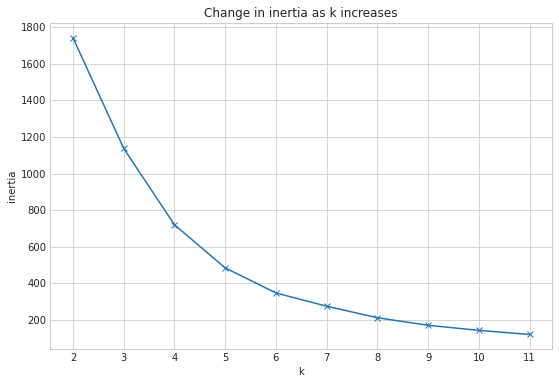

In [14]:
X_train, X_validate, X_test = generate_elbow_plot(train_scaled, validate_scaled, test_scaled, ['age', 'has_investments'])

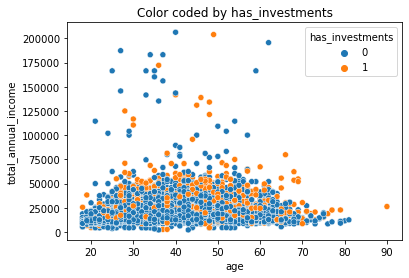

In [15]:
fit_clusters(train, validate, test, X_train, X_validate, X_test, 6, 'investment_cluster', 'age', 'total_annual_income',\
             'has_investments')

In [16]:
investment_dict = {'cluster_0' : '30_40_yr_no_investments', 'cluster_1' : '40_plus_has_investments',\
                  'cluster_2' : '50_plus_no_investments', 'cluster_3' : '40_50_yr_no_investments', \
                  'cluster_4' : '20_30_yr_no_investments', 'cluster_5' : '20_40_yr_has_investments'}

train = rename_clusters(investment_dict, train, 'investment_cluster')
validate = rename_clusters(investment_dict, validate, 'investment_cluster')
test = rename_clusters(investment_dict, test, 'investment_cluster')

In [17]:
X_train, X_validate, X_test = generate_elbow_plot(train_scaled, validate_scaled, test_scaled, ['age', 'is_public'])

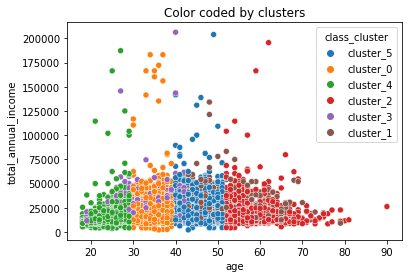

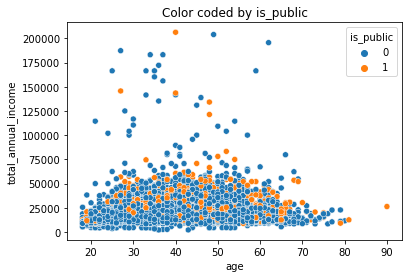

In [18]:
fit_clusters(train, validate, test, X_train, X_validate, X_test, 6, 'class_cluster', 'age', 'total_annual_income',\
             'is_public')

In [19]:
class_dict = {'cluster_0' : '30_40_yr_private', 'cluster_1' : '40_plus_public',\
                  'cluster_2' : '50_plus_private', 'cluster_3' : '20_40_yr_public', \
                  'cluster_4' : '20_30_yr_private', 'cluster_5' : '40_50_yr_private'}

train = rename_clusters(class_dict, train, 'class_cluster')
validate = rename_clusters(class_dict, validate, 'class_cluster')
test = rename_clusters(class_dict, test, 'class_cluster')

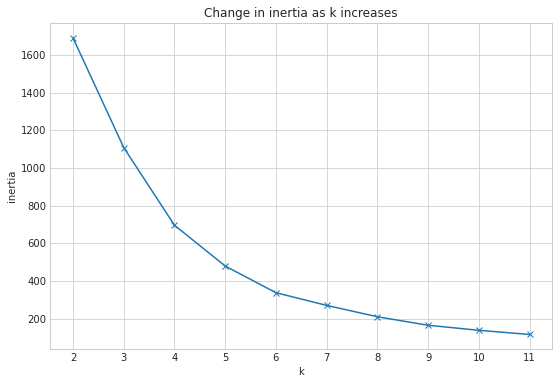

In [20]:
X_train, X_validate, X_test = generate_elbow_plot(train_scaled, validate_scaled, test_scaled, ['age', 'White'])

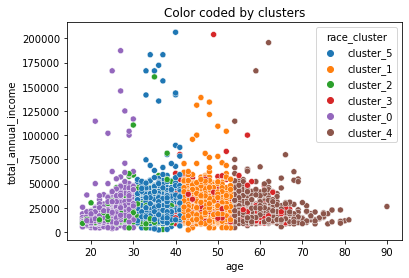

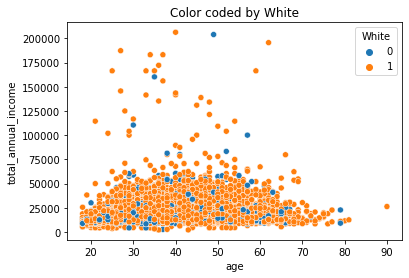

In [21]:
fit_clusters(train, validate, test, X_train, X_validate, X_test, 6, 'race_cluster', 'age', 'total_annual_income',\
             'White')

In [22]:
race_dict = {'cluster_0' : '20_30_yr_white', 'cluster_1' : '40_55_yr_white',\
                  'cluster_2' : '20_40_yr_not_white', 'cluster_3' : '40_plus_not_white', \
                  'cluster_4' : '55_plus_white', 'cluster_5' : '30_40_yr_white'}

train = rename_clusters(race_dict, train, 'race_cluster')
validate = rename_clusters(race_dict, validate, 'race_cluster')
test = rename_clusters(race_dict, test, 'race_cluster')

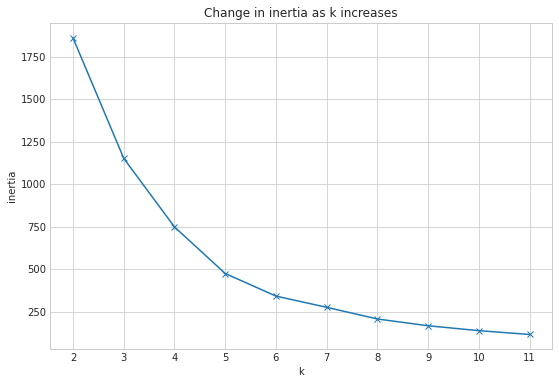

In [23]:
X_train, X_validate, X_test = generate_elbow_plot(train_scaled, validate_scaled, test_scaled, ['age', 'belongs_to_union'])

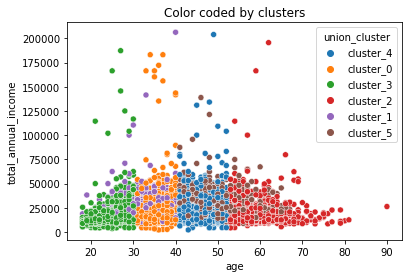

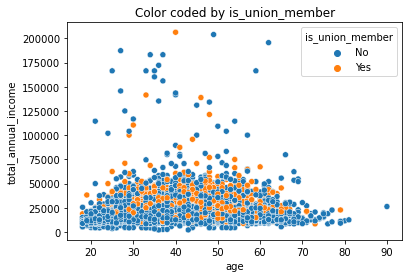

In [24]:
fit_clusters(train, validate, test, X_train, X_validate, X_test, 6, 'union_cluster', 'age', 'total_annual_income',\
             'is_union_member')

In [25]:
union_dict = {'cluster_0' : '30_40_yr_non_union', 'cluster_1' : '20_40_yr_union',\
                  'cluster_2' : '50_plus_non_union', 'cluster_3' : '20_30_yr_non_union', \
                  'cluster_4' : '40_50_yr_non_union', 'cluster_5' : '40_plus_union'}

train = rename_clusters(union_dict, train, 'union_cluster')
validate = rename_clusters(union_dict, validate, 'union_cluster')
test = rename_clusters(union_dict, test, 'union_cluster')

## Modeling
Hourly wage, capital gains, capital losses, and total dividends were not used in the model since they were used to calculate the target.

### First iteration
For the first iteration I used race, union status, marriage status, sex, and class.

In [12]:
non_model_cols = ['worker_class', 'education', 'hourly_wage', 'highest_education', 'marital_status', 'major_industry_code', \
                 'major_occupation_code', 'race', 'of_hispanic_origin', 'sex', 'is_union_member', 'unemployed_reason', \
                 'employment_status', 'capital_gains', 'capital_losses', 'total_dividends', 'tax_filer_status', 'region', 'state',\
                 'family_status', 'household_summary', 'lived_in_house_last_year', 'company_size', 'family_members_under_18',\
                 'country_of_father', 'country_of_mother', 'birth_country', 'citizenship', 'is_self_employed', 'weeks_worked', 'year']

In [13]:
splits = utils.generate_xy_splits(train, validate, test, target='total_annual_income', drop_columns=non_model_cols)

In [14]:
X_train = splits['X_train']
X_validate = splits['X_validate']
X_test = splits['X_test']

y_train = splits['y_train']
y_validate = splits['y_validate']
y_test = splits['y_test']

In [15]:
utils.generate_baseline_model(y_train.total_annual_income.mean(), 'income_mean_pred', 'total_annual_income', y_train, y_validate)

RMSE using income_mean_pred
Train/In-Sample:  14372.034 
Validate/Out-of-Sample:  14660.4248
--------------------------------------------------
Train
Explained variance:  0.0
R-squared value:  0.0
--------------------------------------------------
Validate
Explained variance:  0.0
R-squared value:  -0.0004


In [16]:
utils.generate_baseline_model(y_train.total_annual_income.median(), 'income_median_pred', 'total_annual_income', y_train, y_validate)

RMSE using income_median_pred
Train/In-Sample:  14851.4768 
Validate/Out-of-Sample:  15199.7373
--------------------------------------------------
Train
Explained variance:  0.0
R-squared value:  -0.0678
--------------------------------------------------
Validate
Explained variance:  0.0
R-squared value:  -0.0753


In [17]:
ols = utils.generate_regression_model(LinearRegression(normalize=True), X_train, X_validate, y_train, y_validate,\
                                'income_pred_lm', 'total_annual_income')

RMSE using income_pred_lm
Train/In-Sample:  13717.0299 
Validate/Out-of-Sample:  13962.5114
--------------------------------------------------
Train
Explained variance:  0.0891
R-squared value:  0.0891
--------------------------------------------------
Validate
Explained variance:  0.093
R-squared value:  0.0926


In [18]:
lars = utils.generate_regression_model(LassoLars(alpha=1.0), X_train, X_validate, y_train, y_validate,\
                                 'income_pred_lars', 'total_annual_income')

RMSE using income_pred_lars
Train/In-Sample:  13718.2086 
Validate/Out-of-Sample:  13965.0395
--------------------------------------------------
Train
Explained variance:  0.0889
R-squared value:  0.0889
--------------------------------------------------
Validate
Explained variance:  0.0927
R-squared value:  0.0923


In [19]:
glm = utils.generate_regression_model(TweedieRegressor(power=1, alpha=1), X_train, X_validate, y_train, y_validate,\
                                'income_pred_glm', 'total_annual_income')

RMSE using income_pred_glm
Train/In-Sample:  13730.0946 
Validate/Out-of-Sample:  13977.968
--------------------------------------------------
Train
Explained variance:  0.0873
R-squared value:  0.0873
--------------------------------------------------
Validate
Explained variance:  0.091
R-squared value:  0.0906


In [21]:
grad = utils.generate_regression_model(GradientBoostingRegressor(), X_train, X_validate, y_train ,y_validate, \
                                      'income_pred_grad', 'total_annual_income')

RMSE using income_pred_grad
Train/In-Sample:  13258.5418 
Validate/Out-of-Sample:  13759.3792
--------------------------------------------------
Train
Explained variance:  0.149
R-squared value:  0.149
--------------------------------------------------
Validate
Explained variance:  0.1193
R-squared value:  0.1188


In [20]:
pf = PolynomialFeatures(degree=2)
poly = LinearRegression(normalize=True)

X_train_poly = pf.fit_transform(X_train)
X_validate_poly = pf.transform(X_validate)
X_test_poly = pf.transform(X_test)

poly = utils.generate_regression_model(poly, X_train_poly, X_validate_poly, y_train, y_validate, 'income_pred_poly', 'total_annual_income')

RMSE using income_pred_poly
Train/In-Sample:  13456.7664 
Validate/Out-of-Sample:  13805.7063
--------------------------------------------------
Train
Explained variance:  0.1233
R-squared value:  0.1233
--------------------------------------------------
Validate
Explained variance:  0.1135
R-squared value:  0.1129


The gradient boosting regressor performed the best with an explained variance score of 12% in out-of-sample data.

### Second iteration
For the second iteration I incorporpated all the different clusters into the models.

In [26]:
def encode_clusters(df):
    marriage_dummies = pd.get_dummies(df.marriage_cluster, drop_first=True)
    education_dummies = pd.get_dummies(df.education_cluster, drop_first=True)
    investment_dummies = pd.get_dummies(df.investment_cluster, drop_first=True)
    class_dummies = pd.get_dummies(df.class_cluster, drop_first=True)
    race_dummies = pd.get_dummies(df.race_cluster, drop_first=True)
    union_dummies = pd.get_dummies(df.union_cluster, drop_first=True)
    
    return pd.concat([df, marriage_dummies, education_dummies, investment_dummies, class_dummies, race_dummies, union_dummies], axis=1)

In [27]:
train = encode_clusters(train)
validate = encode_clusters(validate)
test = encode_clusters(test)

In [37]:
drop_cols = ['age', 'worker_class', 'education', 'hourly_wage', 'marital_status',
       'major_industry_code', 'major_occupation_code', 'race',
       'of_hispanic_origin', 'sex', 'is_union_member', 'capital_gains',
       'capital_losses', 'total_dividends', 'household_summary',
       'company_size', 'country_of_father', 'country_of_mother',
       'birth_country', 'citizenship', 'is_self_employed', 'weeks_worked',
       'year', 'has_investments',
       'is_public', 'Male', 'White', 'belongs_to_union', 'is_college_grad',
       'is_high_school_grad', 'is_post_grad', 'not_high_school_grad',
       'marriage_cluster', 'education_cluster', 'investment_cluster',
       'class_cluster', 'race_cluster', 'union_cluster', 'cluster_1',
       'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6']

In [38]:
splits = utils.generate_xy_splits(train, validate, test, 'total_annual_income', drop_cols)

In [39]:
X_train = splits['X_train']
X_validate = splits['X_validate']
X_test = splits['X_test']

y_train = splits['y_train']
y_validate = splits['y_validate']
y_test = splits['y_test']

In [40]:
ols = utils.generate_regression_model(LinearRegression(normalize=True), X_train, X_validate, y_train, y_validate,\
                                'income_pred_lm', 'total_annual_income')

RMSE using income_pred_lm
Train/In-Sample:  13266.4191 
Validate/Out-of-Sample:  13493.8717
--------------------------------------------------
Train
Explained variance:  0.1479
R-squared value:  0.1479
--------------------------------------------------
Validate
Explained variance:  0.1529
R-squared value:  0.1525


In [41]:
lars = utils.generate_regression_model(LassoLars(alpha=1.0), X_train, X_validate, y_train, y_validate,\
                                 'income_pred_lars', 'total_annual_income')

RMSE using income_pred_lars
Train/In-Sample:  13277.3971 
Validate/Out-of-Sample:  13500.9183
--------------------------------------------------
Train
Explained variance:  0.1465
R-squared value:  0.1465
--------------------------------------------------
Validate
Explained variance:  0.152
R-squared value:  0.1516


In [42]:
glm = utils.generate_regression_model(TweedieRegressor(power=2, alpha=1), X_train, X_validate, y_train, y_validate,\
                                'income_pred_glm', 'total_annual_income')

RMSE using income_pred_glm
Train/In-Sample:  14043.0372 
Validate/Out-of-Sample:  14324.8449
--------------------------------------------------
Train
Explained variance:  0.0454
R-squared value:  0.0453
--------------------------------------------------
Validate
Explained variance:  0.0459
R-squared value:  0.0449


In [43]:
grad = utils.generate_regression_model(GradientBoostingRegressor(), X_train, X_validate, y_train ,y_validate, \
                                      'income_pred_grad', 'total_annual_income')

RMSE using income_pred_grad
Train/In-Sample:  13030.8749 
Validate/Out-of-Sample:  13453.1904
--------------------------------------------------
Train
Explained variance:  0.1779
R-squared value:  0.1779
--------------------------------------------------
Validate
Explained variance:  0.158
R-squared value:  0.1576


In [44]:
pf = PolynomialFeatures(degree=2)
poly = LinearRegression(normalize=True)

X_train_poly = pf.fit_transform(X_train)
X_validate_poly = pf.transform(X_validate)
X_test_poly = pf.transform(X_test)

poly = utils.generate_regression_model(poly, X_train_poly, X_validate_poly, y_train, y_validate, 'income_pred_poly', 'total_annual_income')

RMSE using income_pred_poly
Train/In-Sample:  13005.6785 
Validate/Out-of-Sample:  2883513770672170.0
--------------------------------------------------
Train
Explained variance:  0.1811
R-squared value:  0.1811
--------------------------------------------------
Validate
Explained variance:  -3.868525201324391e+22
R-squared value:  -3.86998172436704e+22


The gradient boosting regressor performed the best again with an explained variance score of 16% on out-of-sample data.

## Evaluation
I applied the gradient boosting regressor model to the test data and got an explained variance score of 18%. This amount is the same as the model got on the training sample!

In [45]:
utils.apply_model_to_test_data(grad, X_test, y_test, 'income_pred_grad', 'total_annual_income')

RMSE for income_pred_grad model
Out-of-Sample Performance: 12798.663886601227
Explained variance:  0.1824
R-squared value:  0.1823


In [46]:
utils.better_than_baseline(y_test.total_annual_income, y_test.income_pred_grad)

----------------------------------------------
             model
sse   3.628298e+11
ess   7.895575e+10
tss   4.417856e+11
mse   1.638058e+08
rmse  1.279866e+04
----------------------------------------------
          baseline
sse   4.437125e+11
mse   2.003217e+08
rmse  1.415350e+04
----------------------------------------------
The MODEL performs better than the baseline with an SSE value of 362829840980.0518 and delta of -80882636643.61102


True

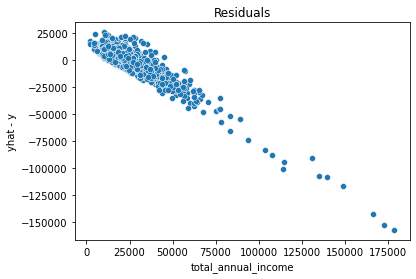

In [47]:
utils.plot_residuals(y_test.total_annual_income, y_test.income_pred_grad)

As you can see, there is a still a downward trend when plotting the residuals, so the underlying trend in the data is still uncaptured by the model.

## Delivery

### Conclusions
1. Age is correlated with income and was an important factor in the clusters
2. I may need to shift the problem I am trying to tackle and change my methods
3. I was able to increase the explained variance from 0% to 18% between baseline and final model.

### Recommendations
1. Bin the different incomes into ranges and use a classification model to predict which range
    * This is still an improvement over the original research model that only predicted under 50_000 or not
2. Incorporate industry and occupation data into clusters
3. Most of the incomes seem to be under 75_000, so try to create a model for only those incomes